# Checking radar line cross points

Finding the crossing points to quality control the radar bed picking. ie have we picked the same bed on different lines?

this time with the shapely intersection function

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal
from tqdm.notebook import tqdm

from shapely.geometry import Point, LineString, Polygon, MultiPoint
import fiona
from shapely.ops import nearest_points

In [2]:
bed_gdf = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed.shp')

In [3]:
bed_gdf.head()

,CDP,x,y,DELAY,line_name,SEQnum,camp,geometry
0,100,-381564.6,-725999.7,8790,line7,1,KIS2,POINT (-381564.600 -725999.700)
1,101,-381563.4,-725998.3,8790,line7,1,KIS2,POINT (-381563.400 -725998.300)
2,102,-381561.6,-725996.1,8790,line7,1,KIS2,POINT (-381561.600 -725996.100)
3,103,-381559.5,-725993.6,8790,line7,1,KIS2,POINT (-381559.500 -725993.600)
4,104,-381557.4,-725991.1,8790,line7,1,KIS2,POINT (-381557.400 -725991.100)


# Convert all lines to a shapely LineString

In [8]:
linestrings = []
names = []

for line_name in bed_gdf.line_name.unique():
    linestrings.append( LineString(bed_gdf[bed_gdf.line_name==line_name].geometry.tolist() ) )
    names.append(line_name)
#put the lines in a geodataframe
lines_gdf = gpd.GeoDataFrame({'line_name':names},geometry=linestrings)
lines_gdf.set_index('line_name',inplace=True)
lines_gdf.head()

,geometry
line_name,
line7,"LINESTRING (-381564.600 -725999.700, -381563.4..."
line9,"LINESTRING (-380741.900 -721788.100, -380743.5..."
line0,"LINESTRING (-377572.000 -734075.100, -377571.8..."
line10,"LINESTRING (-385757.300 -724442.800, -385756.3..."
line11,"LINESTRING (-384056.400 -720106.700, -384057.5..."


# Convert all lines to a shapely MultiPoint

In [9]:
multipoints = []
names_m = []

for line_name in bed_gdf.line_name.unique():
    multipoints.append( MultiPoint(bed_gdf[bed_gdf.line_name==line_name].geometry.tolist() ) )
    names_m.append(line_name)
#put the lines in a geodataframe, lines_mtp multipoint
lines_mtp = gpd.GeoDataFrame({'line_name':names},geometry=multipoints)
lines_mtp.set_index('line_name',inplace=True)
lines_mtp.head()

,geometry
line_name,
line7,"MULTIPOINT (-381564.600 -725999.700, -381563.4..."
line9,"MULTIPOINT (-380741.900 -721788.100, -380743.5..."
line0,"MULTIPOINT (-377572.000 -734075.100, -377571.8..."
line10,"MULTIPOINT (-385757.300 -724442.800, -385756.3..."
line11,"MULTIPOINT (-384056.400 -720106.700, -384057.5..."


### find intersections

In [ ]:
lines_gdf.index

In [ ]:
line0s = []
line1s = []
intersection_point=[]

for line_name in lines_gdf.index.tolist():
    
    if not lines_gdf.loc['line6'].geometry.intersects(lines_gdf.loc['lineAPRESdown'].geometry)

In [ ]:
lines_gdf.loc['line6'].intersects(lines_gdf.'lineapresdownchan'].geometry)

In [ ]:
intersection_table = pd.DataFrame({})

for line_name in lines_gdf.index.tolist():

    intersection_table[line_name+'_'] = lines_gdf.geometry.intersection(lines_gdf.loc[line_name].geometry)

In [ ]:
intersection_bool = pd.DataFrame({}) # boolean dataframe of whether theres an intersection

for line_name in lines_gdf.index.tolist():

    intersection_bool[line_name+'_'] = lines_gdf.geometry.intersects(lines_gdf.loc[line_name].geometry)

In [ ]:
#to make this swifter we'll convert to numpy array
iv = intersection_table.values
ib = intersection_bool.values
np.fill_diagonal(ib,False) #set diagonals to nan

In [ ]:
iv[~ib] = np.nan

In [ ]:
intersection_table = pd.DataFrame(data = iv, columns= lines_gdf.index.tolist())

In [ ]:
intersection_table['line_name'] = lines_gdf.index.tolist()
intersection_table.set_index('line_name',inplace=True)

In [ ]:
intersection_table.line7.dropna()

In [ ]:
intersection_table.lineAPRESdown.dropna()

In [ ]:
intersection_table.to_pickle('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/lines_intersectionpoints.pkl')

In [ ]:
intersection_bool = pd.DataFrame(data = ib, columns= lines_gdf.index.tolist())
intersection_bool['line_name'] = lines_gdf.index.tolist()
intersection_bool.set_index('line_name',inplace=True)
intersection_bool.line7.head()

In [ ]:
#which lines intersect with which
intersection_bool.to_pickle('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/lines_intersects_boolean.pkl')

In [17]:
a,b = nearest_points(lines_mtp.loc['line7'].geometry,lines_mtp.loc['line8'].geometry)
print(a.wkt,b.wkt)

POINT (-380296.8 -724611.8) POINT (-381159.7 -723834.7)


# Using nearest_points make the same table as intersection_table but with tuples of points from the lines

In [18]:
listofrows = []
for line_name0 in lines_gdf.index.tolist():
    row = []
    for line_name1 in lines_gdf.index.tolist():        
        row.append( nearest_points(lines_mtp.loc[line_name0].geometry,lines_mtp.loc[line_name1].geometry) )
    listofrows.append(row)

In [19]:
nearest_points_table = pd.DataFrame(data=listofrows, columns = lines_gdf.index.tolist())
nearest_points_table['line_name'] = lines_gdf.index.tolist()
nearest_points_table.set_index('line_name',inplace=True)

In [20]:
nearest_points_table.head()

,line7,line9,line0,line10,line11,line12,line13,line14,line1,line250,...,left46,left79,left810,right1112,right1314,right13,right24,right68,right910,line5
line_name,,,,,,,,,,,,,,,,,,,,,
line7,"(POINT (-381564.6 -725999.7), POINT (-381564.6...","(POINT (-379471.7 -723757.5), POINT (-381065.4...","(POINT (-381564.6 -725999.7), POINT (-375351 -...","(POINT (-379506.8 -723793.7), POINT (-382482.7...","(POINT (-380261.2 -724574.5), POINT (-384405.8...","(POINT (-381103.1 -725464.4), POINT (-386882.2...","(POINT (-381075.9 -725435.5), POINT (-387797.9...","(POINT (-381075.9 -725435.5), POINT (-389217.9...","(POINT (-381564.6 -725999.7), POINT (-376491 -...","(POINT (-378995.7 -723264.8), POINT (-334455 -...",...,"(POINT (-378995.7 -723264.8), POINT (-377898 -...","(POINT (-379013 -723281.4), POINT (-379027.1 -...","(POINT (-379047.5 -723315.1), POINT (-379938.4...","(POINT (-381564.6 -725999.7), POINT (-387514.3...","(POINT (-381564.6 -725999.7), POINT (-391106.5...","(POINT (-381564.6 -725999.7), POINT (-379422.6...","(POINT (-381564.6 -725999.7), POINT (-379981.4...","(POINT (-381564.6 -725999.7), POINT (-382001.1...","(POINT (-381564.6 -725999.7), POINT (-383945.9...","(POINT (-379749.6 -724075.7), POINT (-378099.3..."
line9,"(POINT (-381065.4 -722134), POINT (-379471.7 -...","(POINT (-380741.9 -721788.1), POINT (-380741.9...","(POINT (-382203.7 -723326.1), POINT (-374781.9...","(POINT (-381259.5 -722307.5), POINT (-382482.7...","(POINT (-381651.1 -722705.4), POINT (-384218.5...","(POINT (-383950.1 -725092.2), POINT (-388050.6...","(POINT (-383790.8 -724929.7), POINT (-388879.4...","(POINT (-382914.8 -724011.1), POINT (-389399.3...","(POINT (-382196.6 -723318.9), POINT (-375437.3...","(POINT (-380741.9 -721788.1), POINT (-334455 -...",...,"(POINT (-380741.9 -721788.1), POINT (-377898 -...","(POINT (-380741.9 -721788.1), POINT (-380734.9...","(POINT (-380865.1 -721900.4), POINT (-380865.4...","(POINT (-383950.1 -725092.2), POINT (-387514.3...","(POINT (-383950.1 -725092.2), POINT (-391106.5...","(POINT (-383950.1 -725092.2), POINT (-379422.6...","(POINT (-383950.1 -725092.2), POINT (-379981.4...","(POINT (-383855.6 -724996.7), POINT (-383017.3...","(POINT (-383937.5 -725079.8), POINT (-383945.9...","(POINT (-382195.2 -723317.4), POINT (-378886.8..."
line0,"(POINT (-375351 -731659.2), POINT (-381564.6 -...","(POINT (-374781.9 -731037.1), POINT (-382203.7...","(POINT (-377572 -734075.1), POINT (-377572 -73...","(POINT (-374781.9 -731037.1), POINT (-383697.7...","(POINT (-374781.9 -731037.1), POINT (-384760 -...","(POINT (-375841.8 -732170.2), POINT (-387395.1...","(POINT (-374781.9 -731037.1), POINT (-387797.9...","(POINT (-374781.9 -731037.1), POINT (-389207.5...","(POINT (-375930.6 -732263), POINT (-376855 -73...","(POINT (-374781.9 -731037.1), POINT (-334455 -...",...,"(POINT (-374781.9 -731037.1), POINT (-376819.9...","(POINT (-374781.9 -731037.1), POINT (-379027.1...","(POINT (-374781.9 -731037.1), POINT (-379938.4...","(POINT (-377128.4 -733566), POINT (-387514.3 -...","(POINT (-377538.9 -734007.1), POINT (-391106.5...","(POINT (-377306.6 -733755.7), POINT (-378261.1...","(POINT (-376973.5 -733406.3), POINT (-378801.5...","(POINT (-375853 -732181.7), POINT (-381116 -72...","(POINT (-375945.7 -732279.5), POINT (-383945.9...","(POINT (-375346 -731653.8), POINT (-379840.2 -..."
line10,"(POINT (-382482.7 -721042.4), POINT (-379506.8...","(POINT (-382482.7 -721042.4), POINT (-381259.5...","(POINT (-383697.7 -722250.3), POINT (-374781.9...","(POINT (-385757.3 -724442.8), POINT (-385757.3...","(POINT (-383482.1 -722011.1), POINT (-384747.3...","(POINT (-384951.8 -723551), POINT (-387560 -72...","(POINT (-384456.1 -723026.1), POINT (-388300.9...","(POINT (-384456.1 -723026.1), POINT (-389686.4...","(POINT (-383691.5 -722243.9), POINT (-375541.7...","(POINT (-382482.7 -721042.4), POINT (-334455 -...",...,"(POINT (-382482.7 -721042.4), POINT (-377898 -...","(POINT (-382482.7 -721042.4), POINT (-380747.9...","(POINT (-382482.7 -721042.4), 

In [22]:
# This file has the closest two points of each 2 lines 
nearest_points_table.to_pickle('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/nearest_points_table.pkl')

# Now run through the nearest points and get errors.

## first mark 'intersection'=True on the bed_df file

In [3]:
nearest_points_raw = pd.read_pickle('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/nearest_points_table.pkl')
intersection_bool = pd.read_pickle('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/lines_intersects_boolean.pkl')

In [4]:
print(nearest_points_raw.loc['line7','lineAPRESdown'][0].wkt,nearest_points_raw.loc['line7','lineAPRESdown'][1].wkt)

POINT (-380790.8 -725148.8) POINT (-380791.1 -725148.1)


In [5]:
#to make this swifter we'll convert to numpy array
nearp = nearest_points_raw.values
ib = intersection_bool.values

In [6]:
nearp[~ib] = np.nan

In [10]:
# This dataframe near_points_at_intersection has the closest two points of each 2 lines, just for the lines which intersect
near_points_at_intersection = pd.DataFrame(data = nearp, columns= lines_gdf.index.tolist())
near_points_at_intersection['line_name'] = lines_gdf.index.tolist()
near_points_at_intersection.set_index('line_name',inplace=True)
near_points_at_intersection.line7.dropna()

line_name
lineAPRESdown    (POINT (-380791.1 -725148.1), POINT (-380790.8...
lineupchan       (POINT (-380743.3 -725104.8), POINT (-380743.7...
Name: line7, dtype: object

In [11]:
tuples_at_intersections = [] #tuples of coordinates at intersections
line_names = []
for line_name in lines_gdf.index.tolist():
    
    tuples_at_intersections.extend( near_points_at_intersection.loc[line_name].dropna().tolist()  )
    line_names.append(line_name)

In [28]:
tuples_of_delay = []
tuples_of_indicies = []
tuples_of_line_names = []

for tup in tuples_at_intersections:
    
    i0 = bed_gdf[bed_gdf.geometry==tup[0]].index[0]
    i1 = bed_gdf[bed_gdf.geometry==tup[1]].index[0]
    tuples_of_indicies.append( (i0,i1) )
    
    tuples_of_delay.append( (int(bed_gdf.loc[i0].DELAY),int(bed_gdf.loc[i1].DELAY) ))
    tuples_of_line_names.append( ( bed_gdf.loc[i0].line_name , bed_gdf.loc[i1].line_name ))

# Now compare the delays

In [29]:
tuples_range = []

for tup in tuples_of_delay:
    tuples_range.append( tup[0] - tup[1] )

In [44]:
distance_between_error_points = [tup[0].distance(tup[1]) for tup in tuples_at_intersections]

In [45]:
intersections_df = gpd.GeoDataFrame(geometry = [tup[0] for tup in tuples_at_intersections]) #just one of the two
intersections_df['delay_error'] = tuples_range
intersections_df['distance_between_error_points'] = distance_between_error_points
intersections_df['intersecting_line_1'] =  [tup[0] for tup in tuples_of_line_names]
intersections_df['intersecting_line_2'] =  [tup[1] for tup in tuples_of_line_names]
intersections_df['point_at_intersection_1'] = [tup[0].wkt for tup in tuples_at_intersections]
intersections_df['points_at_intersection_2'] = [tup[1].wkt for tup in tuples_at_intersections]

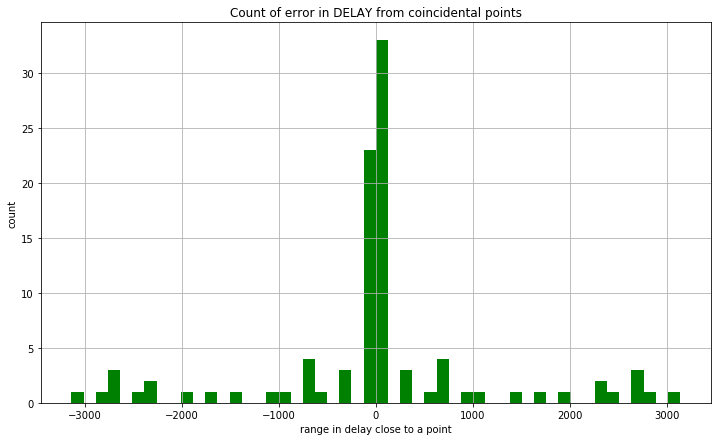

In [15]:
plt.figure(figsize=(12,7))
plt.hist(tuples_range, 50, density=False, facecolor='g')
plt.grid()
plt.title('Count of error in DELAY from coincidental points')
plt.xlabel('range in delay close to a point')
plt.ylabel('count')
plt.show()

In [16]:
# delay_at_intersections = list(sum(tuples_of_delay, ()))
# indicies_at_intersections = list(sum(tuples_of_delay, ()))

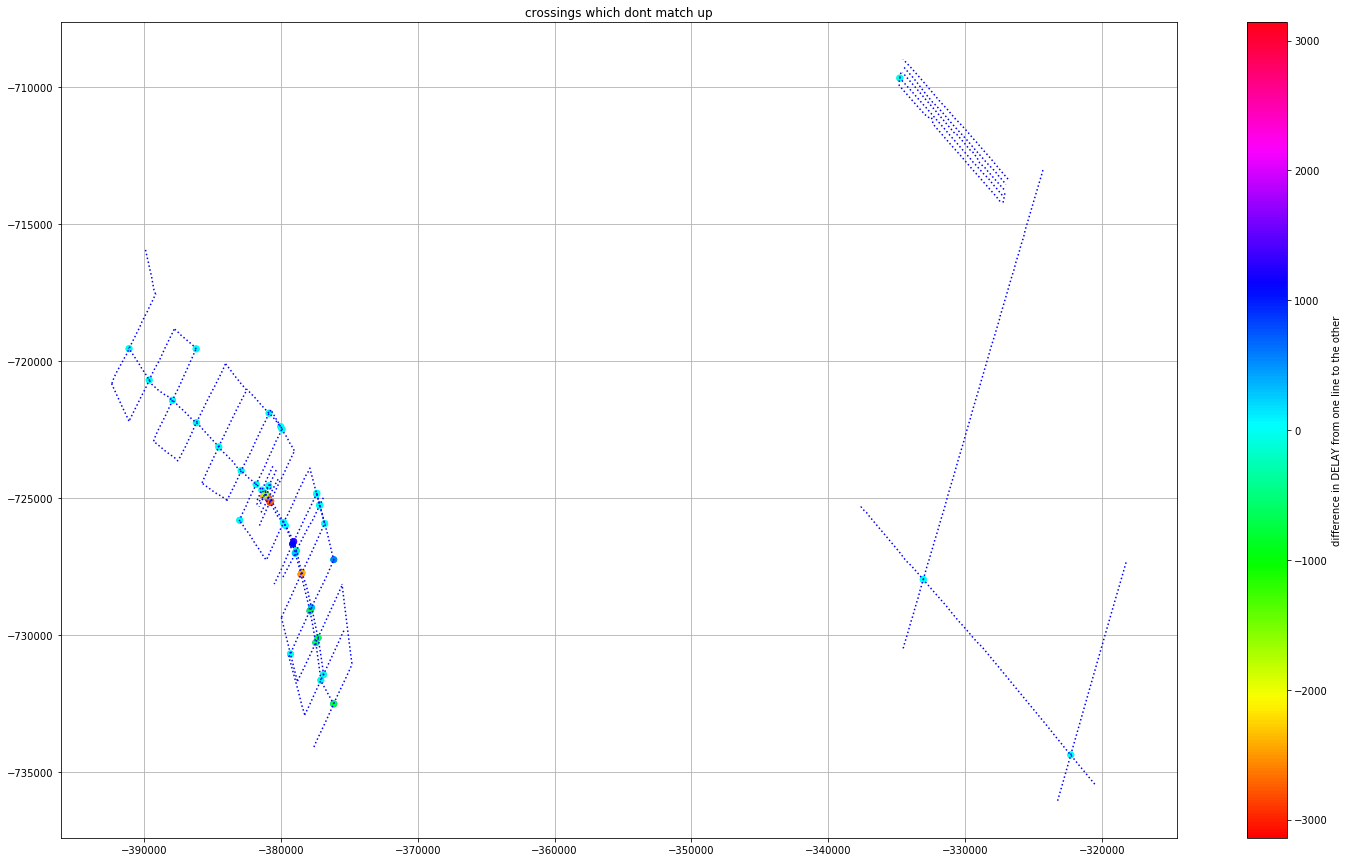

In [17]:
plt.figure(figsize=(25,15))
for line in bed_gdf.line_name.unique().tolist():
    plt.plot(bed_gdf[bed_gdf.line_name==line].x,bed_gdf[bed_gdf.line_name==line].y,'b:')
plt.scatter(intersections_df.geometry.x,intersections_df.geometry.y,c=intersections_df.delay_error,cmap='hsv')
cb = plt.colorbar()
cb.set_label('difference in DELAY from one line to the other')
plt.grid()
plt.title('crossings which dont match up')
plt.show()

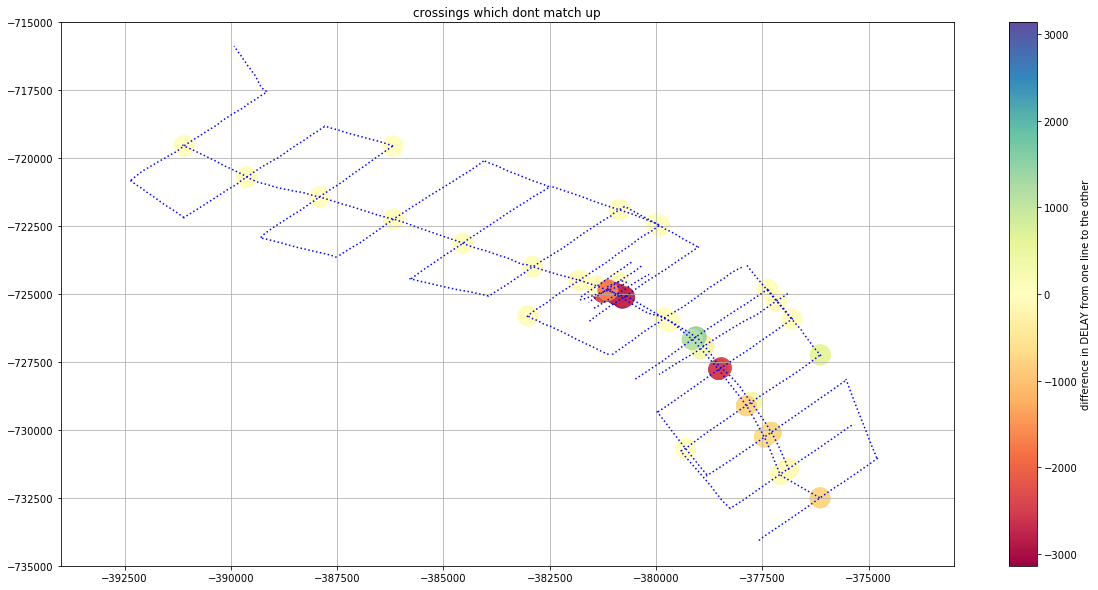

In [18]:
plt.figure(figsize=(20,10))
for line in bed_gdf.line_name.unique().tolist():
    plt.plot(bed_gdf[bed_gdf.line_name==line].x,bed_gdf[bed_gdf.line_name==line].y,'b:')
plt.scatter(intersections_df.geometry.x,intersections_df.geometry.y,c=intersections_df.delay_error,
            cmap='Spectral',s=400)
plt.xlim([-394000,-373000 ])
plt.ylim([-735000,-715000 ])
cb = plt.colorbar()
cb.set_label('difference in DELAY from one line to the other')
plt.grid()
plt.title('crossings which dont match up')
plt.show()

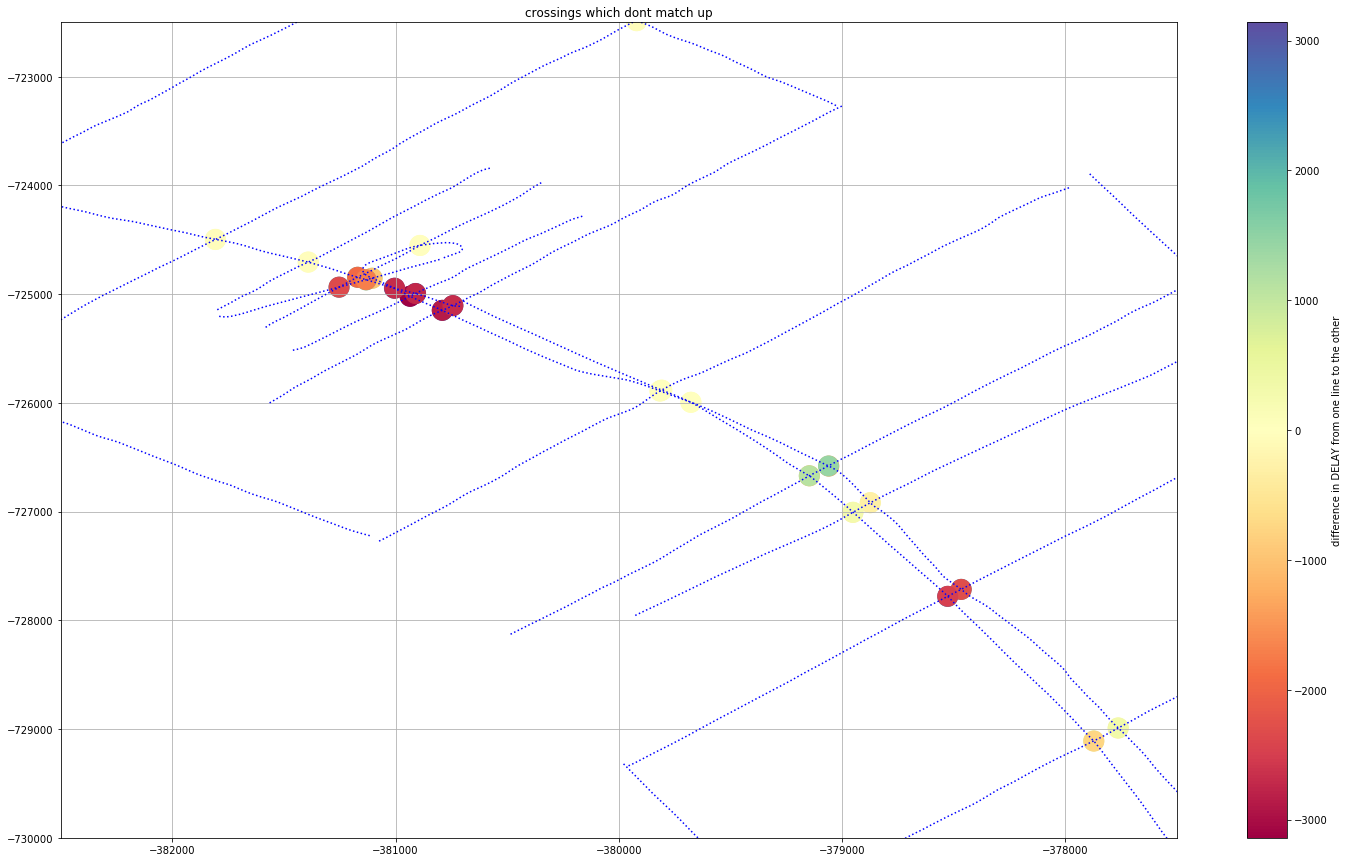

In [19]:
plt.figure(figsize=(25,15))
for line in bed_gdf.line_name.unique().tolist():
    plt.plot(bed_gdf[bed_gdf.line_name==line].x,bed_gdf[bed_gdf.line_name==line].y,'b:')
plt.scatter(intersections_df.geometry.x,intersections_df.geometry.y,c=intersections_df.delay_error,
            cmap='Spectral',s=400)
plt.xlim([-382500,-377500 ])
plt.ylim([-730000,-722500 ])
cb = plt.colorbar()
cb.set_label('difference in DELAY from one line to the other')
plt.grid()
plt.title('crossings which dont match up')
plt.show()

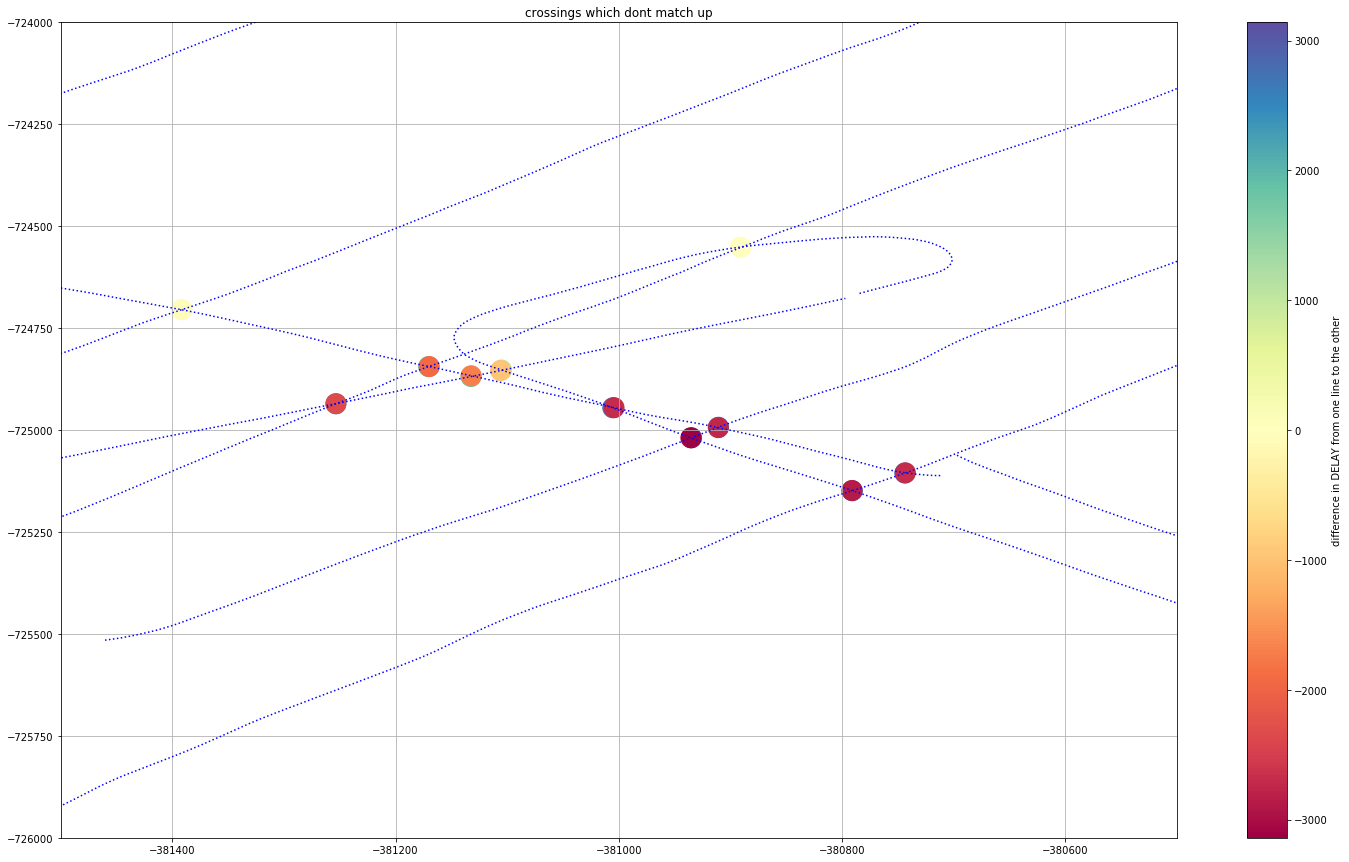

In [20]:
plt.figure(figsize=(25,15))
for line in bed_gdf.line_name.unique().tolist():
    plt.plot(bed_gdf[bed_gdf.line_name==line].x,bed_gdf[bed_gdf.line_name==line].y,'b:')
plt.scatter(intersections_df.geometry.x,intersections_df.geometry.y,c=intersections_df.delay_error,
            cmap='Spectral',s=400)
plt.xlim([-381500,-380500 ])
plt.ylim([-726000,-724000 ])
cb = plt.colorbar()
cb.set_label('difference in DELAY from one line to the other')
plt.grid()
plt.title('crossings which dont match up')
plt.show()

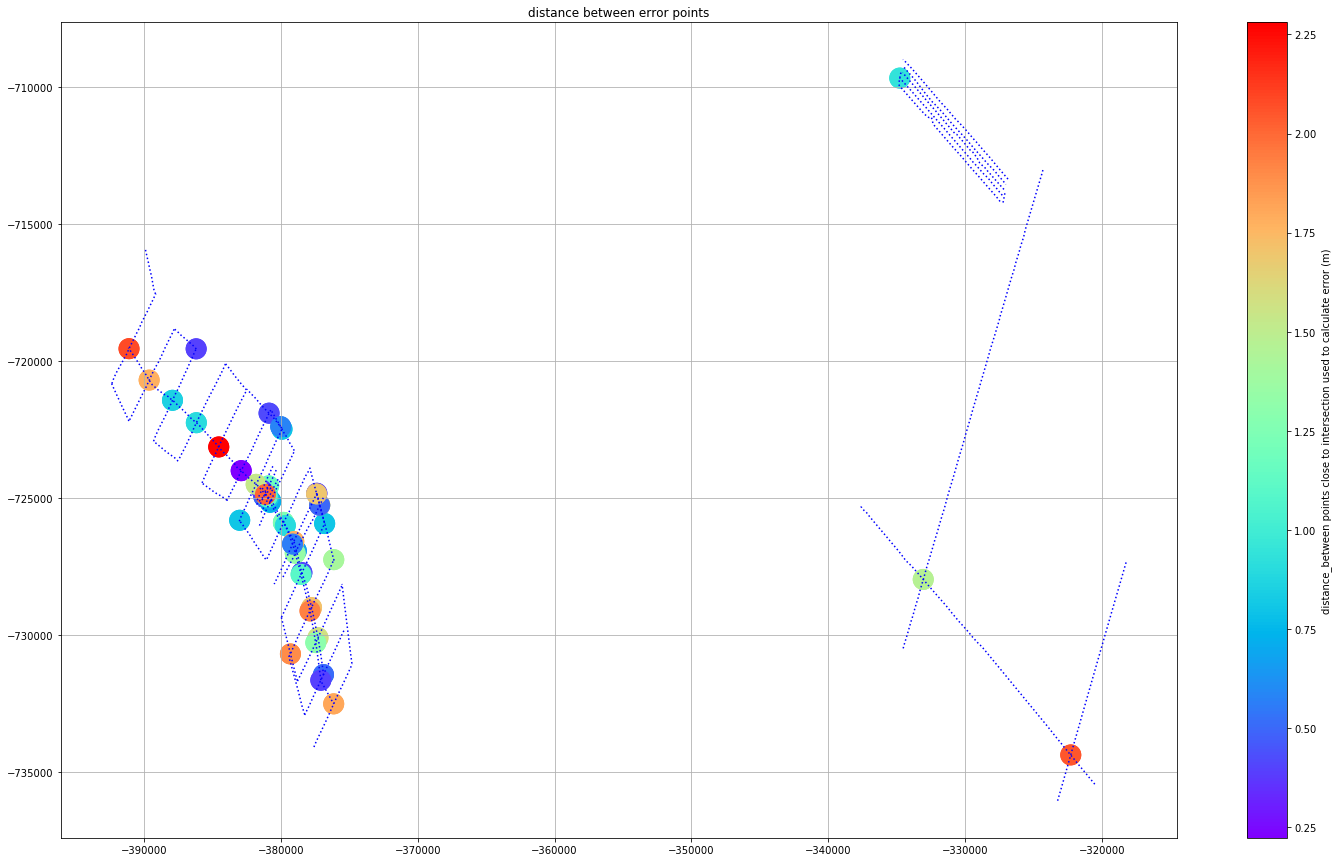

In [53]:
plt.figure(figsize=(25,15))
for line in bed_gdf.line_name.unique().tolist():
    plt.plot(bed_gdf[bed_gdf.line_name==line].x,bed_gdf[bed_gdf.line_name==line].y,'b:')
plt.scatter(intersections_df.geometry.x,intersections_df.geometry.y,c=intersections_df.distance_between_error_points,
            cmap='rainbow',s=400)
cb = plt.colorbar()
cb.set_label('distance_between points close to intersection used to calculate error (m)')
plt.grid()
plt.title('distance between error points')
plt.show()

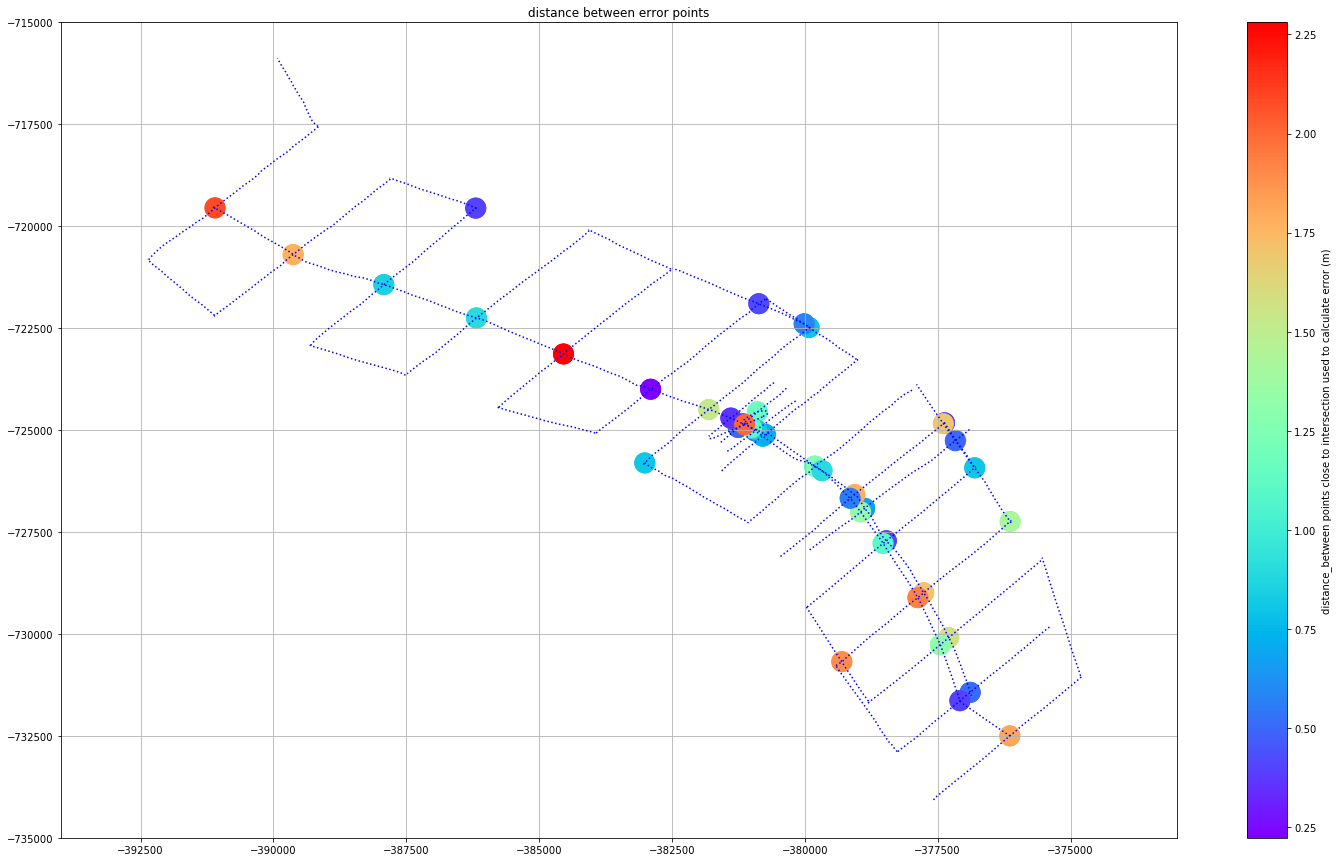

In [51]:
plt.figure(figsize=(25,15))
for line in bed_gdf.line_name.unique().tolist():
    plt.plot(bed_gdf[bed_gdf.line_name==line].x,bed_gdf[bed_gdf.line_name==line].y,'b:')
plt.scatter(intersections_df.geometry.x,intersections_df.geometry.y,c=intersections_df.distance_between_error_points,
            cmap='rainbow',s=400)
plt.xlim([-394000,-373000 ])
plt.ylim([-735000,-715000 ])
cb = plt.colorbar()
cb.set_label('distance_between points close to intersection used to calculate error (m)')
plt.grid()
plt.title('distance between error points')
plt.show()

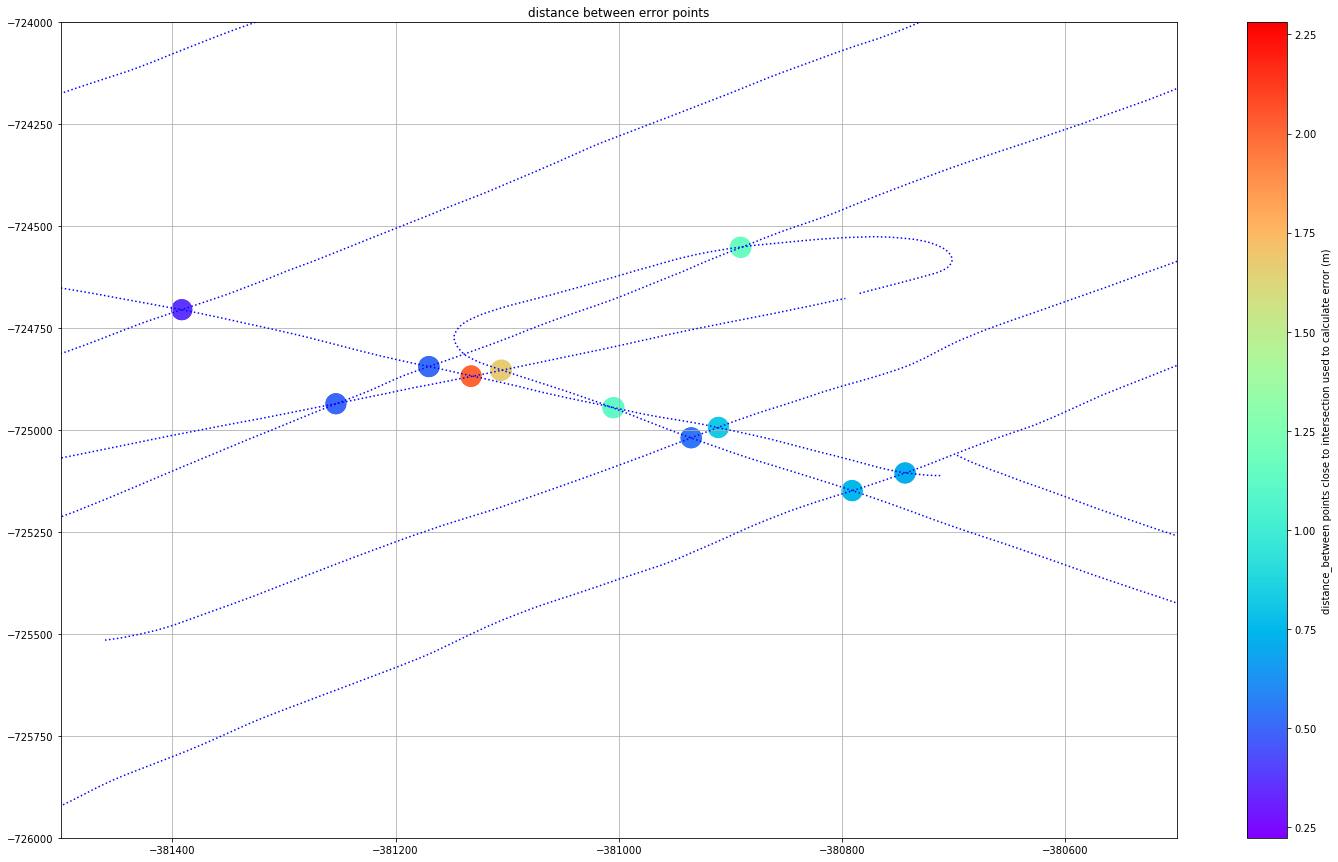

In [52]:
plt.figure(figsize=(25,15))
for line in bed_gdf.line_name.unique().tolist():
    plt.plot(bed_gdf[bed_gdf.line_name==line].x,bed_gdf[bed_gdf.line_name==line].y,'b:')
plt.scatter(intersections_df.geometry.x,intersections_df.geometry.y,c=intersections_df.distance_between_error_points,
            cmap='rainbow',s=400)
plt.xlim([-381500,-380500 ])
plt.ylim([-726000,-724000 ])
cb = plt.colorbar()
cb.set_label('distance_between points close to intersection used to calculate error (m)')
plt.grid()
plt.title('distance between error points')
plt.show()

# Save the delay errors

In [46]:
intersections_df

,geometry,delay_error,distance_between_error_points,intersecting_line_1,intersecting_line_2,point_at_intersection_1,points_at_intersection_2
0,POINT (-380790.800 -725148.800),2866,0.761577,line7,lineAPRESdown,POINT (-380790.8 -725148.8),POINT (-380791.1 -725148.1)
1,POINT (-380743.700 -725105.400),2680,0.721110,line7,lineupchan,POINT (-380743.7 -725105.4),POINT (-380743.3 -725104.8)
2,POINT (-382901.200 -723997.000),40,0.223607,line9,lineupchan,POINT (-382901.2 -723997),POINT (-382901.3 -723997.2)
3,POINT (-380865.100 -721900.400),40,0.424264,line9,left810,POINT (-380865.1 -721900.4),POINT (-380865.4 -721900.1)
4,POINT (-376142.000 -732500.300),753,1.811077,line0,linedownchan,POINT (-376142 -732500.3),POINT (-376142.2 -732498.5)
...,...,...,...,...,...,...,...
93,POINT (-383010.900 -725804.900),-40,0.806226,right68,line8,POINT (-383010.9 -725804.9),POINT (-383011 -725805.7)
94,POINT (-379060.600 -726579.800),1438,1.780449,line5,lineAPRESdown,POINT (-379060.6 -726579.8),POINT (-379059.2 -726580.9)
95,POINT (-379146.700 -726670.200),1111,0.565685,line5,linedownchan,POINT (-379146.7 -726670.2),POINT (-379146.3 -726670.6)
96,POINT (-377372.100 -724821.800),30,0.400000,line5,left35,POINT (-377372.1 -724821.8),POINT (-377371.7 -724821.8)


In [47]:
intersections_df.to_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/delay_error_at_intersections.shp')